In [3]:
# For reloading modules
import importlib

# My modules
import datasets
import utils
import models
import train
import config as cfg
import display as disp

import time
import tensorflow as tf
import numpy as np

# Video and visualization stuff
import tqdm
import PIL.Image, PIL.ImageDraw

from IPython.display import Image, HTML, clear_output, Video
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import matplotlib.pyplot as plt
from visdom import Visdom

In [137]:
# Reload modules
importlib.reload(utils)
importlib.reload(models)
importlib.reload(datasets)
importlib.reload(cfg)
importlib.reload(train)
importlib.reload(disp)

<module 'display' from '/home/maxi/Documents/UNI/Thesis/dev/SoS/display.py'>

In [138]:
# Load Dataset & Model & Trainer
(x_train, y_train), (x_test, y_test) = datasets.get_data()
ca = models.CAModel()

# In order to use visdom, visdom.sh has to be executed
vis = Visdom()
trainer = train.Trainer(x_train, y_train, ca, vis)
ca.summary()

Setting up a new session...


pool size  (80, 40, 40, 16)
Model: "perceive"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (1, 3, 3, 80)             11600     
Total params: 11,600
Trainable params: 11,600
Non-trainable params: 0
_________________________________________________________________
perceive:  None
------------
Model: "dmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (1, 3, 3, 16)             1296      
Total params: 1,296
Trainable params: 1,296
Non-trainable params: 0
_________________________________________________________________
dmodel:  None


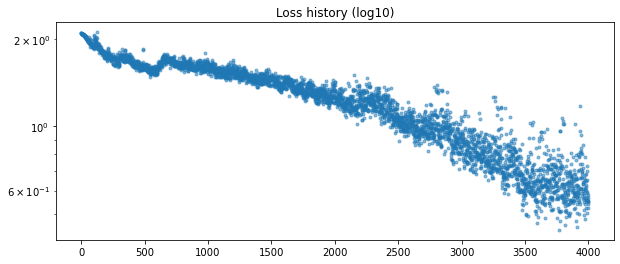

 step: 4000, log10(loss): 0.565

In [149]:
NUM_TRAINING_STEPS = 2000

# Not sure about the level of abstraction here, might be too much
for i in range(1, NUM_TRAINING_STEPS+1):
  x, x0, loss = trainer.full_train_step()
  trainer.visualize(x, x0, loss)


In [44]:
# For visualization on visdom (need to run visdom.sh first)
trainer.scatter_simple("self assigned seed ratio")

In [153]:
# Show cut image (run again for new box)
x0 = trainer.cut_x(trainer.pool_t[:8])
# print(x0.shape)
disp.show_simple_run(x0[0:1], trainer.ca, cfg.CA_STEP_RANGE[0] + 180)

In [152]:
# Show full run from initial seed
disp.show_simple_run(x_train, trainer.ca, cfg.CA_STEP_RANGE[0] + 180)

get_new_x_y


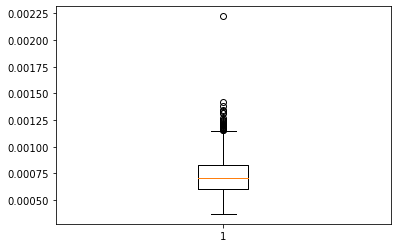

update_step


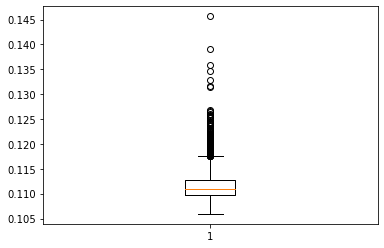

full_train_step


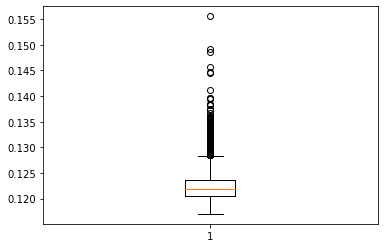

visualize


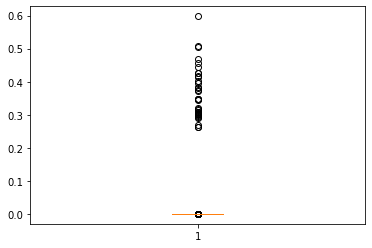

In [14]:
# Show execution times as boxplots
for key in utils.total_time_dict.keys():
  print(key)
  # Removing the first as most time too long and not representative
  plt.boxplot(utils.total_time_dict[key][1:])
  plt.show()

In [ ]:
# TODO outsource
def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = models.eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
  return all_accuracies, all_agreements


In [ ]:
eval_batch = 1000
num_iters = 10

# TODO this takes ages!
start_time = time.time()
all_accuracies, all_agreements = eval_all(trainer.ca, num_steps=200, mutate=True)
print("All Acc time: ", time.time() - start_time)

plt.figure(figsize=(10, 4))
plt.title('Average cell accuracy over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average cell accuracy (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_accuracies, label="ca")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Average total agreement across batch over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average total agreement (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_agreements, label="ca")
plt.legend()

In [ ]:
importlib.reload(datasets)
importlib.reload(utils)
importlib.reload(cfg)
importlib.reload(models)

ca = models.CAModel()

# There is a way without plt, and with PIL, but this is easy for me
emoji = datasets.Emoji("lizard")
# utils.imshow(utils.zoom(emoji.emoji_img, 4))
# utils.imshow(utils.zoom(emoji.emoji_rgb, 4))
# emoji.show_emoji()
# print(datasets.init_seed().shape)

seed = datasets.init_seed()
# utils.imshow(utils.zoom(1 - datasets.init_seed()[0,:,:,:3], 4))
utils.imshow(1-utils.zoom(ca(ca(ca(seed)))[0,:,:,:3],4))

In [ ]:
ca.summary()

"""
eval_bs= 100
num_steps = 400 

ca = get_model(add_noise=False, loss_type='ce')
make_run_videos(ca, num_steps, eval_bs, "ce_runs", disable_black=True)
mvp.ipython_display('ce_runs.mp4')
"""

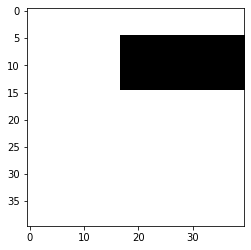

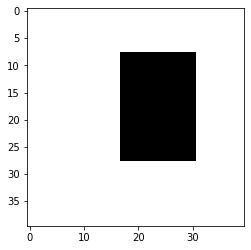

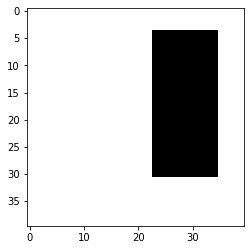

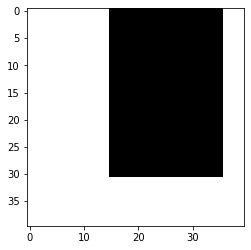

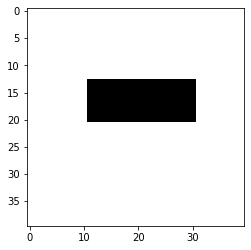

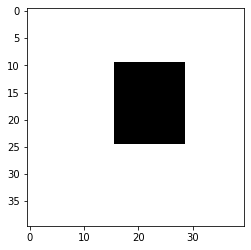

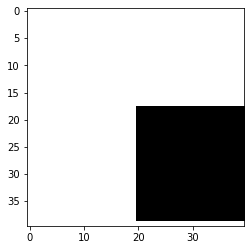

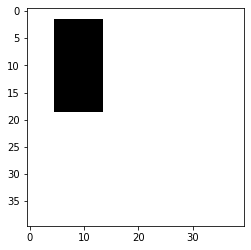

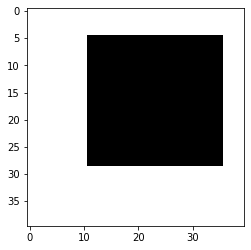

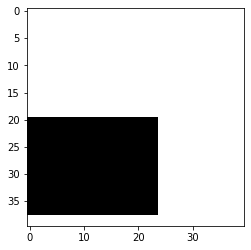

In [83]:
x = np.ones((40, 40, 3))

def cut_x(x):
  x = np.copy(x)
  # Assuming x is squared
  box_size_range_x = [x.shape[0]*0.2, x.shape[0]*0.8]
  box_size_range_y = [x.shape[1]*0.2, x.shape[1]*0.8]
  box_width = np.random.randint(*box_size_range_x)
  box_height = np.random.randint(*box_size_range_y)
  
  # Randomly select the middle coordinates of the box
  box_x_mid = np.random.randint(x.shape[0]*0.2, x.shape[0]*0.8)
  box_y_mid = np.random.randint(x.shape[1]*0.2, x.shape[1]*0.8)
  
  box_x = max(0, box_x_mid - int(box_width/2))
  box_y = max(0, box_y_mid - int(box_height/2))
  
  # check boundaries
  box_x_end = min(x.shape[0], box_x + box_width)
  box_y_end = min(x.shape[1], box_y + box_height)
  
  # apply cut
  x[box_x:box_x_end, box_y:box_y_end, :] = 0
  return x
  
# cut_x(x)
for i in range(10):
  plt.imshow(cut_x(x))
  plt.show()